# Presentation

In [1]:
using SARProcessing, Images, Statistics, SciPy, Plots, Dates

In [2]:
## small cheat function to easy load the test data 
const folder = "../test/testData/largeFiles/EO_workshop/"

function load_test_slc_image(folder, image_number)
    tiffs = ["S1A_IW_SLC__1SDV_20190622T015048.tiff","S1B_IW_SLC__1SDV_20190628T014958.tiff",
     "S1A_IW_SLC__1SDV_20190704T015049.tiff", "S1B_IW_SLC__1SDV_20190710T014959.tiff" ]
    annotation_files = ["s1a-iw2-slc-vv-20190622t015048-20190622t015113-027786-0322f1-005.xml",
    "s1b-iw2-slc-vv-20190628t014958-20190628t015023-016890-01fc87-005.xml",
     "s1a-iw2-slc-vv-20190704t015049-20190704t015114-027961-03283a-005.xml",
     "s1b-iw2-slc-vv-20190710t014959-20190710t015024-017065-0201b8-005.xml"]

    tiff_file = tiffs[image_number]
    is_S1A = split(tiff_file,"_")[1] == "S1A"

    window = is_S1A ? [[100 , 1500],[7600 , 20000]] : [[4*1506 , 4*1506+1600],[7500 , 20100]]

    metadata = SARProcessing.Sentinel1MetaData(joinpath(folder, annotation_files[image_number]))
    index_start = (window[1][1],window[2][1])
    data = SARProcessing.load_tiff(joinpath(folder, tiff_file))

    return SARProcessing.Sentinel1SLC(metadata,index_start,data,false)
end

load_test_slc_image (generic function with 1 method)

### Load and visualize a SAR image

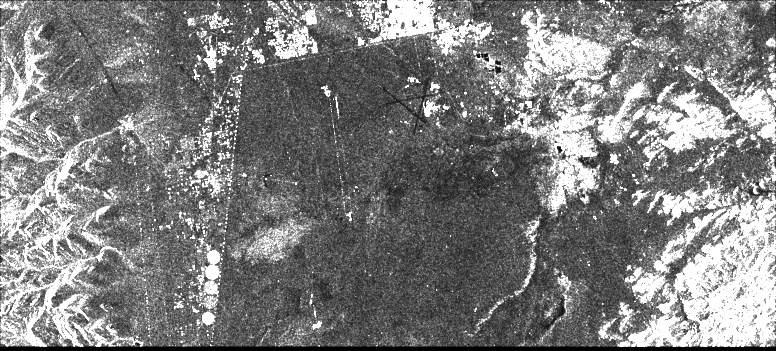

In [3]:
sar_image = load_test_slc_image(folder,1);
SARProcessing.sar2gray(sar_image.data[:,1:4:end])

In [17]:
## the data is just a complex array
sar_image.data[300:303,400:404]

4×5 Matrix{ComplexF64}:
  23.0-24.0im    17.0-23.0im  -31.0+7.0im   -79.0+28.0im   -71.0+44.0im
   6.0-14.0im   -13.0-12.0im    0.0+0.0im    25.0+55.0im    10.0+48.0im
 -21.0-24.0im   -20.0-45.0im   -4.0+9.0im     2.0+26.0im   -70.0-38.0im
 -61.0+43.0im  -114.0+33.0im  -21.0+25.0im    1.0+57.0im  -112.0+101.0im

### Load orbit file and create interpolator

In [45]:
orbit_sate_file_path = joinpath(folder,"S1A_OPER_AUX_POEORB_OPOD_20210330T183728_V20190621T225942_20190623T005942.EOF");
orbit_states =  SARProcessing.load_precise_orbit_sentinel1(orbit_sate_file_path);

orbit_states[1].time, orbit_states[1].position,orbit_states[1].velocity 

(DateTime("2019-06-21T22:59:42"), [-1.962909282656e6, 4.300927106914e6, 5.255246445313e6], [-499.857794, 5774.883891, -4900.74554])

Create an orbit interpolator using the package

In [5]:
orbit_interpolator = SARProcessing.orbit_state_interpolator(orbit_states,sar_image.metadata);


Plot the interpolate z velocity vs. the one from the orbit states to show the interpolation

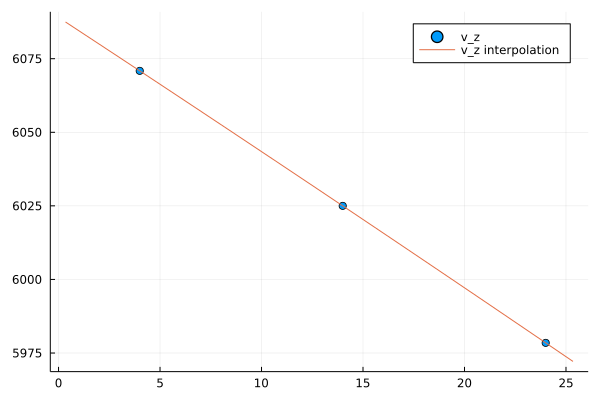

In [10]:

vz_states = [ element.velocity[3] for element in orbit_states]
t_s_states = [ Dates.value.(element.time-sar_image.metadata.reference_time) / 1000 for element in orbit_states] 

image_start = sar_image.metadata.header.start_time
image_stop = sar_image.metadata.header.stop_time

in_image = ((sar_image.metadata.header.start_time -1) .< t_s_states) .& (t_s_states  .< (sar_image.metadata.header.stop_time +1))

t_interpolation = collect(image_start:0.2:image_stop)
vz_interpolation = [orbit_interpolator(t).velocity[3] for t in t_interpolation]

p=scatter(t_s_states[in_image],vz_states[in_image], label="v_z")
plot!(t_interpolation , vz_interpolation, label="v_z interpolation")


## Geolocate the air strip in the picture

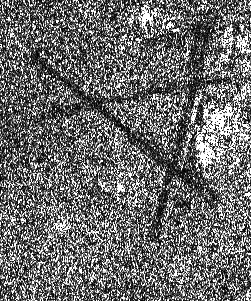

In [11]:
SARProcessing.sar2gray(sar_image.data[300:600,6000:4:7000])

Find the coordinate of the airstrip

In [12]:
# this should be solved with offset arrays
index_of_air_strip = (450 + sar_image.index_start[1] -1, 6500+ sar_image.index_start[2] -1)

height_air_strip = 10 ## just a guess

coordinates_air_strip = SARProcessing.sar_index2geodetic(index_of_air_strip... ,
    height_air_strip,orbit_interpolator,sar_image.metadata)

coordinates_air_strip[1:2] .*180/pi

2-element Vector{Float64}:
   35.68832440994117
 -117.70472737718411

Check the coordinate with google map

https://www.google.com/maps/@35.6883244,-117.7047274,3058m/data=!3m1!1e3

There is also a function to go from index to coordinate

In [13]:
index_air_strip_computed = SARProcessing.geodetic2SAR_index(coordinates_air_strip,orbit_interpolator,sar_image.metadata) 

index_air_strip_computed[1]  - sar_image.index_start[1] +1, index_air_strip_computed[2]  - sar_image.index_start[2] +1

(449.99959911223004, 6499.999999999833)

### Use a digital elevation model to get the heights for the pixel in the SAR image

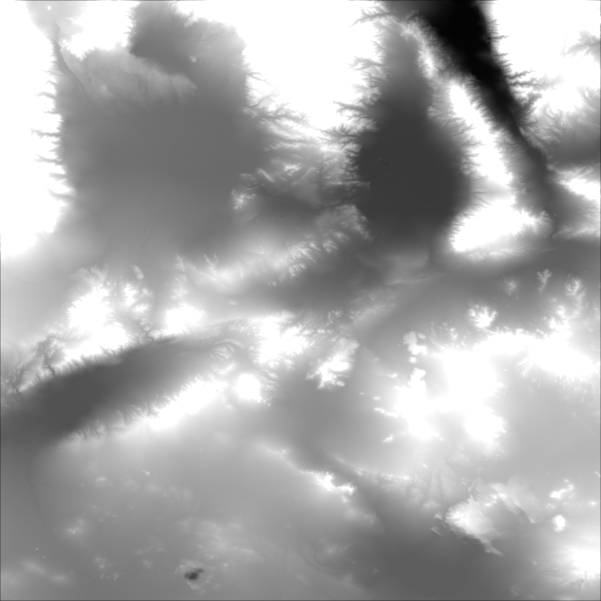

In [23]:
dem = SARProcessing.load_tandemx_dem(folder*"TDM1_DEM__30_N35W118_DEM.tif");
SARProcessing.sar2gray(dem.heights)

In [24]:
# compute radian latitude and longitude for the heights
dem_geodetic_coordinates = 
[  [ (SARProcessing.get_coordinate(dem,(i,j)) .* (pi/180))...,dem.heights[i,j]] for i=1:size(dem.heights)[1], j=1:size(dem.heights)[2]];


In [25]:
# filter the dem to only the heights in the image

dem_geodetic_coordinates = reshape(dem_geodetic_coordinates,:);


dem_in_image = [ 
    SARProcessing.is_coordinate_in_time_range(SARProcessing.geodetic2ecef(coord)
    ,SARProcessing.get_time_range(sar_image.metadata),orbit_interpolator) 
    for coord in dem_geodetic_coordinates] 

dem_geodetic_coordinates = dem_geodetic_coordinates[dem_in_image];

In [26]:
## Get the location of the heights in the SAR image 
dem_sar_index = 
[ [SARProcessing.geodetic2SAR_index(coords, orbit_interpolator, sar_image.metadata)...] 
    for coords in dem_geodetic_coordinates];

# unpack the heights that match
heights = [coords[3] for coords in dem_geodetic_coordinates]

## clean up variables
dem_geodetic_coordinates =nothing
dem_in_image = nothing
dem = nothing


In [56]:
## Create a grid in the SAR image.
# It is not necessary to interpolate the heights for every pixel, just a grid

rows_range = sar_image.index_start[1] : (sar_image.index_start[1] + size(sar_image.data)[1]-1)
columns_range = sar_image.index_start[2] : (sar_image.index_start[2] + size(sar_image.data)[2]-1)

rows = collect( rows_range.start:10:rows_range.stop)
columns =  collect( columns_range.start:40:columns_range.stop)

rows_grid = ones(length(columns))' .* rows
columns_grid = columns' .* ones(length(rows));


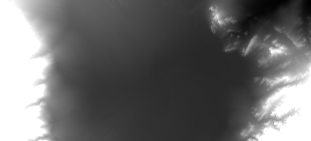

In [57]:
## interpolate the heights to the sar idex grid
interpolated_heights = SciPy.interpolate.griddata(
    hcat(dem_sar_index...)',heights, (reshape(rows_grid,:), reshape(columns_grid,:)) )


interpolated_heights = reshape(interpolated_heights,size(rows_grid))

SARProcessing.sar2gray(interpolated_heights)

### Convert the SAR grid to coordinates
This can also be used to resample the SAR image to a regular coordinate grid

In [43]:
sar_grid_coordinate = [SARProcessing.sar_index2geodetic(rows[i], columns[j] ,interpolated_heights[i,j],
                orbit_interpolator,
                sar_image.metadata) for i=1:length(rows), j=1:length(columns) ];

## print some coordinate to show
[[sar_grid_coordinate[i,j][1:2] .*180 ./pi,sar_grid_coordinate[i,j][3]] for i = 10:13, j=10:11 ]

4×2 Matrix{Vector{Any}}:
 [[35.6102, -117.928], 1070.33]  [[35.6105, -117.926], 1067.96]
 [[35.6115, -117.928], 1081.15]  [[35.6117, -117.926], 1075.83]
 [[35.6128, -117.928], 1090.05]  [[35.613, -117.927], 1079.19]
 [[35.614, -117.928], 1096.17]   [[35.6142, -117.927], 1080.52]

## Convert the SAR grid to locations in a second SAR image 

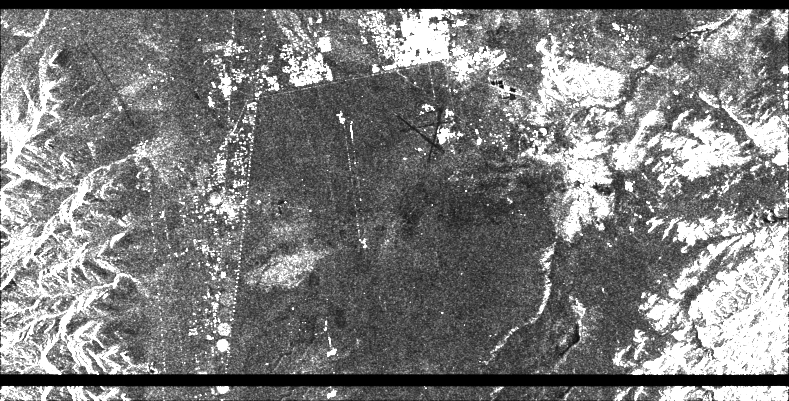

In [59]:
secondary_sar_image = load_test_slc_image(folder, 2);
## We have cheated and selected an area the overlap okey
SARProcessing.sar2gray(secondary_sar_image.data[:,1:4:end])

In [48]:
## create an orbit interpolator for the second image

orbit_sate_file_path2 = joinpath(folder,"S1B_OPER_AUX_POEORB_OPOD_20210330T202915_V20190627T225942_20190629T005942.EOF");
orbit_interpolator2 = SARProcessing.orbit_state_interpolator(
    SARProcessing.load_precise_orbit_sentinel1(orbit_sate_file_path2),
    secondary_sar_image.metadata);


In [49]:
# get the grid in image two indecies
grid_image2 =
    [ [SARProcessing.geodetic2SAR_index(coords, orbit_interpolator2, secondary_sar_image.metadata)...] 
        for coords in sar_grid_coordinate];
    
    
grid_image2[10:13,10:13]

4×4 Matrix{Vector{Float64}}:
 [4213.57, 8089.17]  [4213.57, 8129.18]  …  [4213.57, 8209.18]
 [4223.57, 8089.17]  [4223.57, 8129.18]     [4223.57, 8209.18]
 [4233.57, 8089.17]  [4233.57, 8129.18]     [4233.57, 8209.18]
 [4243.57, 8089.17]  [4243.57, 8129.18]     [4243.57, 8209.18]

The image rows are here a bit confusing. The row is counts a the number of unique rows from the first row in the entire Sentinel 1 swath. It is necessary to adjust for the subset idex offset and the burst overlap to get the actual row in the data. We hope to make this more simple in the future by restructure the data struct and by using the offset arrays package

In [60]:
## deramp the data before resampling
if !secondary_sar_image.deramped
    println("Deramping")
    rows_range2 = secondary_sar_image.index_start[1]:(secondary_sar_image.index_start[1] + size(secondary_sar_image.data)[1]-1)
    columns_range2 = secondary_sar_image.index_start[2]:(secondary_sar_image.index_start[2] + size(secondary_sar_image.data)[2]-1)

    mid_burst_state2 = SARProcessing.get_burst_mid_states(secondary_sar_image, orbit_interpolator2)
    mid_burst_state2 = mid_burst_state2[SARProcessing.get_burst_numbers(secondary_sar_image) .==4]
    mid_burst_speed2 = SARProcessing.get_speed.(mid_burst_state2)[1]

    phase_ramp2 = SARProcessing.phase_ramp(
        collect(rows_range2), 
        collect(columns_range2), 
    4, mid_burst_speed2, secondary_sar_image.metadata)


    secondary_sar_image.data .= secondary_sar_image.data .* exp.(-phase_ramp2 .* im)
    secondary_sar_image.deramped = true;
end

Deramping


true

#### Resample image2 to image1

In [63]:

burst_shift_row2 = (4-1)*secondary_sar_image.metadata.swath.lines_per_burst- SARProcessing.get_burst_row_offset(secondary_sar_image.metadata)[4]

503.00026815125057

In [75]:

image2_row_interpolator = SciPy.interpolate.interp2d(
    columns,rows,[index[1] for index in grid_image2].+ round(Int,burst_shift_row2))

image2_column_interpolator = SciPy.interpolate.interp2d(
        columns,rows,[index[2] for index in grid_image2])

rows_target2 = reshape(image2_row_interpolator(
    collect(columns_range),
    collect(rows_range)),:)

columns_target2 = reshape(image2_column_interpolator(
    collect(columns_range),
    collect(rows_range)),:)

image2_data_interpolator = SciPy.interpolate.RegularGridInterpolator(
    (collect( rows_range2),
    collect( columns_range2)),
    secondary_sar_image.data, bounds_error=false, fill_value=zero(eltype(secondary_sar_image.data)));

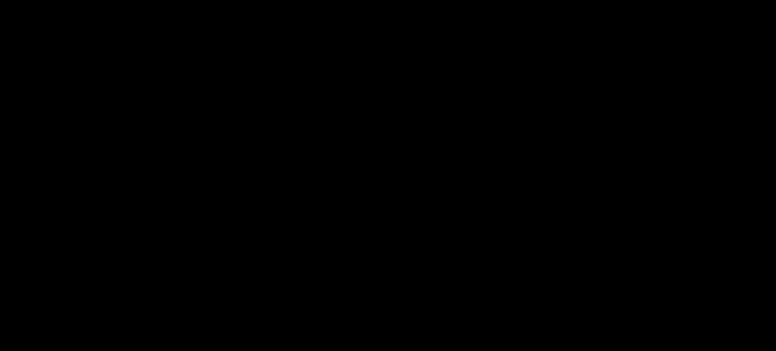

In [76]:
resampled_data = image2_data_interpolator(
    [
        [rows_target2[i],columns_target2[i]] 
        for i =1:length(columns_target2)
    ]
    )
resampled_data = reshape(resampled_data,size(sar_image.data));

SARProcessing.sar2gray(resampled_data[:,1:4:end])